## Imports

In [1]:
import itertools
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from scipy.stats import mannwhitneyu

plt.rcParams["figure.figsize"] = (20,10)

sys.path.append('..')
from const import *
from util import load_advisory_database

## Read, Trasform, and Filter Data

In [2]:
commit_times = pd.read_csv(CSV_DATA['fixes_commits_times'], index_col=False)
commit_times['author_time'] = pd.to_datetime(commit_times['author_time'])
commit_times['committer_time'] = pd.to_datetime(commit_times['committer_time'])
commit_times['pr_created_at'] = pd.to_datetime(commit_times['pr_created_at'])
commit_times['pr_updated_at'] = pd.to_datetime(commit_times['pr_updated_at'])
commit_times['pr_closed_at'] = pd.to_datetime(commit_times['pr_closed_at'])
commit_times['pr_merged_at'] = pd.to_datetime(commit_times['pr_merged_at'])

In [3]:
fixes_labels = pd.read_csv(CSV_DATA['fixes_labels_round_2'], index_col=False)

non_fixes = fixes_labels[(fixes_labels['by'] != 'human') & (fixes_labels['by'] != 'bot')][['repository', 'number', 'package', 'ghsa']].copy()
human_fixes = fixes_labels[fixes_labels['by'] == 'human'][['repository', 'number', 'package', 'ghsa']].copy()
bot_fixes = fixes_labels[fixes_labels['by'] == 'bot'][['repository', 'number', 'package', 'ghsa']].copy()

In [4]:
fixes_commits = pd.read_csv(CSV_DATA['fixes_labels'], index_col=False)
fixes_commits = fixes_commits[["repository", "number", "ghsa", "commit_fix"]]
fixes_commits = fixes_commits.rename(columns = {'commit_fix': 'oid'})

In [5]:
adv_database = load_advisory_database()[['package', 'severity', 'ghsa']].copy()

In [6]:
pr_vuln = pd.read_csv(CSV_DATA['pr_vulnerabilities'], index_col=False)
pr_vuln = pr_vuln[pr_vuln['state'] != 'OPEN']
pr_nums = []
projects = set(pr_vuln['repository'].to_list())
for project in projects:
    pr_nums.append(len(pr_vuln[pr_vuln['repository'] == project].index))
pr_nums = pd.DataFrame({'repository': list(projects), 'prs': pr_nums})

In [7]:
security_updates = pd.read_csv(CSV_DATA['security_updates_commits'],
                               index_col=False)[['repository', 'number', 'created_at']]
security_updates = security_updates.rename(columns={"created_at": "sec_up_cr_at"})
security_updates['sec_up_cr_at'] = pd.to_datetime(security_updates['sec_up_cr_at'])

### Distribute Fixes, Append Necessary Data

In [8]:
non_fixes = non_fixes.merge(adv_database, how = 'inner', on=['package', 'ghsa']).drop_duplicates().merge(
    security_updates, how = 'inner', on=['repository', 'number']
    ).reset_index().drop_duplicates()
non_fixes['end_time'] = pd.to_datetime('2021-04-09T00:00:00Z')
bot_fixes = bot_fixes.merge(fixes_commits, how='inner', on=['repository', 'number', 'ghsa']).merge(
    commit_times, how = 'inner', on=['repository', 'oid']).drop_duplicates().merge(
    adv_database, how = 'inner', on=['package', 'ghsa']).drop_duplicates().merge(
    security_updates, how = 'inner', on=['repository', 'number']
    ).reset_index().drop_duplicates()
human_fixes = human_fixes.merge(fixes_commits, how='inner', on=['repository', 'number', 'ghsa']).merge(
    commit_times, how = 'inner', on=['repository', 'oid']).drop_duplicates().merge(
    adv_database, how = 'inner', on=['package', 'ghsa']).drop_duplicates().merge(
    security_updates, how = 'inner', on=['repository', 'number']
    ).reset_index().drop_duplicates()

### Compute Fixing Times

In [9]:
time_to_fix1 = []
time_to_fix2 = []
time_to_fix3 = []
severity1 = []
severity2 = []
severity3 = []
observed1 = []
observed2 = []
observed3 = []
by1 = []
by2 = []
by3 = []

project1 = []
project2 = []
project3 = []

t1 = pd.to_datetime('2019-09-30T23:59:59Z')
t2 = pd.to_datetime('2020-01-31T23:59:59Z')

for index, row in non_fixes.iterrows():
    time_diff = row['end_time'] - row['sec_up_cr_at']

    if row['sec_up_cr_at'] < t1:
        time_to_fix1.append(time_diff.days + 1)
        observed1.append(False)
        project1.append(row['repository'])
        severity1.append(row['severity'])
        by1.append('none')
    elif row['sec_up_cr_at'] >= t1 and row['sec_up_cr_at'] < t2:
        time_to_fix2.append(time_diff.days + 1)
        observed2.append(False)
        project2.append(row['repository'])
        severity2.append(row['severity'])
        by2.append('none')
    else:
        time_to_fix3.append(time_diff.days + 1)
        observed3.append(False)
        project3.append(row['repository'])
        severity3.append(row['severity'])
        by3.append('none')

    #time_to_fix.append(time_diff.days + 1)
    # severity.append(row['severity'])
    # by.append('none')
    # project.append(row['repository'])
for index, row in bot_fixes.iterrows():
    if row['sec_up_cr_at'] < t1:
        if pd.isna(row['pr_merged_at']):
            time_to_fix1.append(max(1, (row['committer_time'] - row['sec_up_cr_at']).days + 1))
        else:
            time_to_fix1.append(max(1, (row['pr_merged_at'] - row['sec_up_cr_at']).days + 1))
        observed1.append(True)
        project1.append(row['repository'])
        severity1.append(row['severity'])
        by1.append('bot')
    elif row['sec_up_cr_at'] >= t1 and row['sec_up_cr_at'] < t2:
        if pd.isna(row['pr_merged_at']):
            time_to_fix2.append(max(1, (row['committer_time'] - row['sec_up_cr_at']).days + 1))
        else:
            time_to_fix2.append(max(1, (row['pr_merged_at'] - row['sec_up_cr_at']).days + 1))
        observed2.append(True)
        project2.append(row['repository'])
        severity2.append(row['severity'])
        by2.append('bot')
    else:
        if pd.isna(row['pr_merged_at']):
            time_to_fix3.append(max(1, (row['committer_time'] - row['sec_up_cr_at']).days + 1))
        else:
            time_to_fix3.append(max(1, (row['pr_merged_at'] - row['sec_up_cr_at']).days + 1))
        observed3.append(True)
        project3.append(row['repository'])
        severity3.append(row['severity'])
        by3.append('bot')

    # severity.append(row['severity'])
    # by.append('bot')
    # project.append(row['repository'])
human_time_to_fix = []
for index, row in human_fixes.iterrows():
    if row['sec_up_cr_at'] < t1:
        time_to_fix1.append(max(1, (row['committer_time'] - row['sec_up_cr_at']).days + 1))
        observed1.append(True)
        project1.append(row['repository'])
        severity1.append(row['severity'])
        by1.append('human')
    elif row['sec_up_cr_at'] >= t1 and row['sec_up_cr_at'] < t2:
        time_to_fix2.append(max(1, (row['committer_time'] - row['sec_up_cr_at']).days + 1))
        observed2.append(True)
        project2.append(row['repository'])
        severity2.append(row['severity'])
        by2.append('human')
    else:
        time_to_fix3.append(max(1, (row['committer_time'] - row['sec_up_cr_at']).days + 1))
        observed3.append(True)
        project3.append(row['repository'])
        severity3.append(row['severity'])
        by3.append('human')
    # time_to_fix.append(max(1, (row['committer_time'] - row['sec_up_cr_at']).days + 1))
    # severity.append(row['severity'])
    # by.append('human')
    # project.append(row['repository'])
# df_res = pd.DataFrame({'repository': project, 'severity': severity, 'time_to_fix': time_to_fix,
#                        'observed': observed, 'by': by})
# df_res
print(len(time_to_fix1), len(observed1), len(project1), len(severity1), len(by1))
print(len(time_to_fix2), len(observed2), len(project2), len(severity2), len(by2))
print(len(time_to_fix3), len(observed3), len(project3), len(severity3), len(by3))

1628 1628 1628 1628 1628
1917 1917 1917 1917 1917
1433 1433 1433 1433 1433


## Survival Anaylsis: Overall

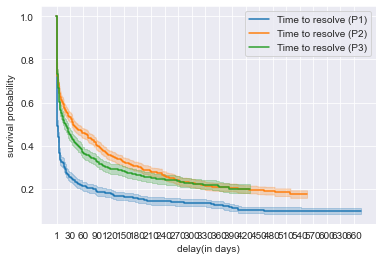

In [10]:
plt.rcParams["figure.figsize"] = (12,4)
kmf1 = KaplanMeierFitter()
a1 = kmf1.fit(durations = time_to_fix1, event_observed = observed1, label='Time to resolve (P1)').plot()
a2 = kmf1.fit(durations = time_to_fix2, event_observed = observed2, label='Time to resolve (P2)').plot()
a3 = kmf1.fit(durations = time_to_fix3, event_observed = observed3, label='Time to resolve (P3)').plot()
ticks = plt.xticks(np.concatenate((np.array([1]), np.arange(30, 690, 30.0)), axis=0))
plt.xlabel("delay(in days)")
plt.ylabel("survival probability")
plt.savefig("survival_analysis_overall.png", dpi=800)

In [11]:
xs = [1, 7, 14, 21, 30, 60, 90, 180, 365]
prob = []
for i in xs:
    prob.append('{:.2f}'.format(kmf1.predict(i)))
res = pd.DataFrame({'x' : xs, 'P(>x)': prob})
res

,x,P(>x)
0,1,0.78
1,7,0.60
2,14,0.53
3,21,0.50
4,30,0.45
5,60,0.37
6,90,0.33
7,180,0.27
8,365,0.21


## Survival Anaylsis: Severity

<AxesSubplot:xlabel='timeline'>

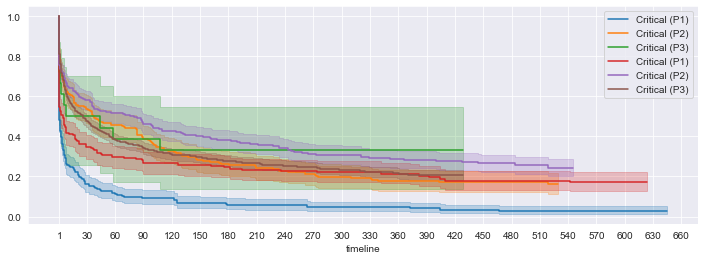

In [14]:
df_res1 = pd.DataFrame({'repository': project1, 'severity': severity1, 'time_to_fix': time_to_fix1,
                       'observed': observed1, 'by': by1})
df_res2 = pd.DataFrame({'repository': project2, 'severity': severity2, 'time_to_fix': time_to_fix2,
                       'observed': observed2, 'by': by2})
df_res3 = pd.DataFrame({'repository': project3, 'severity': severity3, 'time_to_fix': time_to_fix3,
                       'observed': observed3, 'by': by3})

plt.rcParams["figure.figsize"] = (12, 4)
ticks = plt.xticks(np.concatenate((np.array([1]), np.arange(30, 690, 30.0)), axis=0))
## fit the model for 1st cohort
kmf1 = KaplanMeierFitter()
kmf1.fit(df_res1[df_res1['severity'] == 'CRITICAL']['time_to_fix'],
         df_res1[df_res1['severity'] == 'CRITICAL']['observed'], label='Critical (P1)').plot()
kmf1.fit(df_res2[df_res2['severity'] == 'CRITICAL']['time_to_fix'],
         df_res2[df_res2['severity'] == 'CRITICAL']['observed'], label='Critical (P2)').plot()
kmf1.fit(df_res3[df_res3['severity'] == 'CRITICAL']['time_to_fix'],
         df_res3[df_res3['severity'] == 'CRITICAL']['observed'], label='Critical (P3)').plot()



# a1 = kmf1.plot()

# ## fit the model for 2nd cohort
# kmf2 = KaplanMeierFitter()
# kmf2.fit(df_res[df_res['severity'] == 'MODERATE']['time_to_fix'],
#          df_res[df_res['severity'] == 'MODERATE']['observed'], label='moderate')
# a2 = kmf2.plot(ax=a1)
#
# ## fit the model for 3rd cohort
# kmf3 = KaplanMeierFitter()
# kmf3.fit(df_res[df_res['severity'] == 'HIGH']['time_to_fix'],
#          df_res[df_res['severity'] == 'HIGH']['observed'], label='high')
# a3 = kmf3.plot(ax=a2)
#
# ## fit the model for 4th cohort
# kmf4 = KaplanMeierFitter()
# kmf4.fit(df_res[df_res['severity'] == 'CRITICAL']['time_to_fix'],
#          df_res[df_res['severity'] == 'CRITICAL']['observed'], label='critical')
# figure = kmf4.plot(ax=a3)
# plt.xlabel("delay(in days)")
# plt.ylabel("survival probability")
# ticks = plt.xticks(np.concatenate((np.array([1]), np.arange(30, 630, 30.0)), axis=0))
# plt.xlim([1, 620])
# figure.get_figure().savefig("survival_analysis_severity.png", dpi=800)
#
# # hamid
# # total
# kmf5 = KaplanMeierFitter()
# kmf5.fit(df_res['time_to_fix'], df_res['observed'], label='total')

In [13]:
low_prob = []
mod_prob = []
hig_prob = []
cri_prob = []
total_prob = []
for i in xs:
    low_prob.append('{:.2f}'.format(kmf1.predict(i)))
    mod_prob.append('{:.2f}'.format(kmf2.predict(i)))
    hig_prob.append('{:.2f}'.format(kmf3.predict(i)))
    cri_prob.append('{:.2f}'.format(kmf4.predict(i)))
    total_prob.append('{:.2f}'.format(kmf5.predict(i)))
res = pd.DataFrame({'x' : xs, 'low': low_prob, 'moderate': mod_prob, 'high': hig_prob, 'critical': cri_prob, 'total': total_prob})
res

NameError: name 'kmf2' is not defined

In [ ]:
for a, b in itertools.combinations(['LOW', 'MODERATE', 'HIGH', 'CRITICAL'], 2):
    test = logrank_test(df_res[df_res['severity'] == a]['time_to_fix'],
                        df_res[df_res['severity'] == b]['time_to_fix'],
                        df_res[df_res['severity'] == a]['observed'],
                        df_res[df_res['severity'] == b]['observed'])
    print('{} ~ {}: {:.3f} (p-value: {}) reject?: {}'.format(
        a, b, 
        test.test_statistic, test.p_value, test.p_value < 0.05/6
    ))

## Bot Fix vs Human Fix

In [ ]:
groups = []
df_res_group = df_res.merge(pr_nums, how='inner', on=['repository']).copy()
for index, row in df_res_group.iterrows():
    if (row['prs'] > 0) & (row['prs'] < 3):
        groups.append(0)
    elif (row['prs'] > 2) & (row['prs'] < 5):
        groups.append(1)
    elif (row['prs'] > 4) & (row['prs'] < 11):
        groups.append(2)
    elif (row['prs'] > 10) & (row['prs'] < 68):
        groups.append(3)
df_res_group['group'] = groups
df_res_group = df_res_group.sort_values('group')

In [ ]:
plt.rcParams["figure.figsize"] = (20,5)
ax = sns.violinplot(y='by', x='time_to_fix',
                    data=df_res_group[df_res_group['observed']], cut=0,
                    bw=.15, orient='h', linewidth=3, alpha = 0.4)
ok = plt.xticks(np.concatenate((np.array([1]), np.arange(30, 570, 30.0)), axis=0))
plt.xlabel("time to fix (in days)")
plt.savefig("violin_fixes.png", dpi=800)

In [ ]:
mannwhitneyu(df_res_group[(df_res_group['by'] == 'human') & (df_res_group['group'] == 0)]['time_to_fix'],
             df_res_group[(df_res_group['by'] == 'human') & (df_res_group['group'] == 1)]['time_to_fix'])

In [ ]:
plt.rcParams["figure.figsize"] = (20,10)
ax = sns.violinplot(y='group', x='time_to_fix',
                    data=df_res_group[df_res_group['observed']], cut=0,
                    bw=.65, hue='by', orient='h', linewidth=3,
                    order=[0, 1, 2, 3], alpha = 0.4)

for violin, alpha in zip(ax.collections[::2], range(8)):
    violin.set_alpha(0.4)

In [ ]:
by_human = df_res_group[(df_res_group['by'] == 'human')]
by_bot = df_res_group[(df_res_group['by'] == 'bot')]

days = range(60) # 2 month
bot_fix_days = {}
human_fix_days = {}
for i in days:
    bot_fix_days['day-' + str(i)] = len(by_bot[by_bot['time_to_fix'] <= i]) / len(by_bot)
    human_fix_days['day-' + str(i)] = len(by_human[by_human['time_to_fix'] < i]) / len(by_human)